# PIP-PRoS: Predição da trajetória da bola

Neste notebook o algoritmo de predição da trajetória da bola para realizar seu bloqueio é descrito passo a passo. O Algoritmo usa um filtro de Kalman para realizar o cálculo da velocidade da bola e com isso calcular sua trajetória.

Para mais informações, acesse [o site do projeto](https://sites.google.com/tecnico.ulisboa.pt/pip-pros/)!

## Bibliotecas utilizadas

In [130]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [131]:
ball_hsv_lower = (0, 80, 0)
ball_hsv_upper = (20, 250, 200)

minimum_ball_area = 300
maximum_ball_area = 3000

def detect_ball(frame, output_frame):
    # First we blur the image with a GaussianBlur
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    
    # Construct a HSV mask for the green color
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, ball_hsv_lower, ball_hsv_upper)

    # Erode and dilate the result to remove small noises
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    
    # Then we calculate the countours of the resulting image
    frame_cnts, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(output_frame, frame_cnts, -1, (0,0,255), 2)

    if len(frame_cnts) == 0:
        return False, output_frame, [], -1, -1, -1

    # Calculate the circularity of the identified countours
    areas = np.array([cv2.contourArea(c) for c in frame_cnts])
    is_reading_valid = (areas > minimum_ball_area) & (areas < maximum_ball_area)

    if np.sum(is_reading_valid) == 0:
        return False, output_frame, [], -1, -1, -1

    perimeters = np.array([cv2.arcLength(c,True) for c in frame_cnts])

    circularities = 4 * np.pi * areas/(perimeters**2)
    circularities = circularities*is_reading_valid
    ball_cnt_idx = np.argmax(circularities)
    # We get the one with the greatest circularity (4*pi*area/(perimeter^2))
    # https://www.mathworks.com/help/images/identifying-round-objects.html
    c = frame_cnts[ball_cnt_idx]
    # And calculate the minimum enclosing circle
    ((x, y), radius) = cv2.minEnclosingCircle(c)
    M = cv2.moments(c)
    
    # Calculate the shape
    approx = cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True)

    # If the shape is really close to a circle and the area is greater than the minimum
    # the contour is considered to be the ball
    if (len(approx) > 5) & (len(approx) < 23):
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        cv2.circle(output_frame, (int(x), int(y)), int(radius), (0, 255, 0), 2)

        return True, output_frame, frame_cnts, x, y, radius
    return False, output_frame, [], -1, -1, -1

## Vídeo utilizado como exemplo

<video alt="Example video" controls style="max-width:500px">
    <source src="../assets/examples/trajectory.mp4" type="video/mp4">
</video>

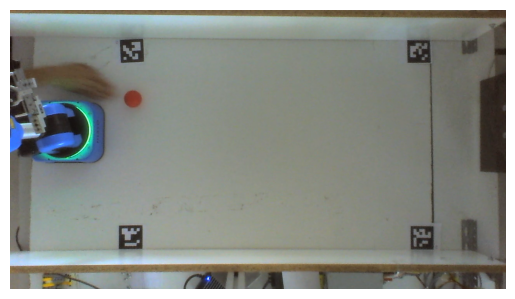

In [132]:
vid_capture = cv2.VideoCapture('../assets/examples/trajectory.mp4')
# Jumping to part of interest of the video
for _ in range(22):
    _, frame = vid_capture.read()

plt.axis("off")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Cálculo da direção de movimento da bola

O filtro de Kalman é [...]

Será utilizada a implementação de [Kalman Filter do próprio OpenCV](https://docs.opencv.org/3.4/dd/d6a/classcv_1_1KalmanFilter.html#details).


O filtro instanciado terá 4 variáveis, que modelam a posição da bola e sua direção de movimento - $x, y, \Delta x, \Delta y$ - no entanto apenas as primeiras duas podem ser medidas diretamente pelo processamento da imagem (pela detecção da posição da bola vista anteriormente).

Dessa forma, a matriz de medição será dada por:

$$ 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1& 0 & 0 
\end{bmatrix}
$$

A matriz de transição, por sua vez, dita como as variáveis evoluem a cada iteração. Dessa forma, como $x_{n+1} = x_n + \Delta x_n$ e assumindo velocidade constante para a bola após lançamento, é possível obter a seguinte matriz de transição:

$$ 
\begin{bmatrix}
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$


In [133]:
kf = cv2.KalmanFilter(4, 2)
kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)

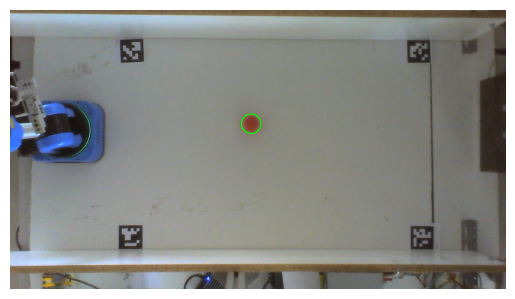

In [138]:
xd_array = []
yd_array = []

for _ in range(2):
    _, frame = vid_capture.read()
    
    is_ball_detected, _, _, x, y, radius = detect_ball(frame, frame)
    
    if is_ball_detected:
        kf.correct(np.array([x, y], dtype=np.float32))
        _, _, xd_pred, yd_pred = kf.predict()

        if xd_pred and yd_pred:
            xd_array.append(xd_pred)
            yd_array.append(yd_pred)


plt.axis("off")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))